In [1]:
import utility as ut
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from datetime import datetime


In [2]:
# File paths
DIRECTORY = "data/"
GANTRY_CRANE_PARAMETERS_JSON_PATH = "gantry_crane_parameters.json"
RESULTS_PATH = "SGD_results/"

In [3]:
# Load data
datasets = ut.load_excel_data(DIRECTORY)

In [4]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

In [5]:
interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_speed = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position_first_derivative"]
    )
    new_cable_speed = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length_first_derivative"]
    )
    new_trolley_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_trolley_motor"]
    )
    new_hoist_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_hoist_motor"]
    )
    new_trolley_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_motor_voltage"]
    )
    new_hoist_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["hoist_motor_voltage"]
    )

    interpolated_df = {
        "time": time_array,
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_speed": new_trolley_speed,
        "cable_speed": new_cable_speed,
        "trolley_motor_pwm": new_trolley_motor_pwm,
        "hoist_motor_pwm": new_hoist_motor_pwm,
        "trolley_motor_voltage": new_trolley_motor_voltage,
        "hoist_motor_voltage": new_hoist_motor_voltage,
    }

    interpolated_datasets.append(interpolated_df)

print(len(interpolated_datasets))


39


In [6]:
max_sway_angle = 0
for i in range(len(interpolated_datasets)):
    max_sway_angle = max(
        max_sway_angle, max(abs(interpolated_datasets[i]["sway_angle"]))
    )

# Sort the interpolated_datasets by average trolley motor PWM from lowest to highest and then by average hoist motor PWM from lowest to highest
interpolated_datasets.sort(key=lambda x: np.mean(x["trolley_motor_pwm"]))
interpolated_datasets.sort(key=lambda x: np.mean(x["hoist_motor_pwm"]))

for key in interpolated_datasets[0]:
    print(key)

time
trolley_position
cable_length
sway_angle
trolley_speed
cable_speed
trolley_motor_pwm
hoist_motor_pwm
trolley_motor_voltage
hoist_motor_voltage


In [7]:
USE_BEST_DATASET = True
best_dataset = []
if USE_BEST_DATASET:
    for index in range(len(interpolated_datasets)):
        if (index >= 9 and index <= 20) or (index >= 30):
            continue
        best_dataset.append(interpolated_datasets[index])
    
    interpolated_datasets = best_dataset

In [8]:
show_interpolated_datasets = False
if show_interpolated_datasets:
    for index, interpolated_dataset in enumerate(interpolated_datasets):
        # if (index >= 9 and index <= 20) or (index >= 30):
        #     continue
        # Create a figure and a set of subplots
        figure, ax = plt.subplots(4, 2, figsize=(14, 9), sharex=True)
        figure.suptitle(f"Interpolated Dataset {index+1}", fontsize=16)
        ut.add_to_subplot(ax[0, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_motor_pwm"], ylabel="PWM motor troli", color="blue")
        ut.add_to_subplot(ax[0, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["hoist_motor_pwm"], ylabel="PWM motor angkut", color="red")
        ut.add_to_subplot(ax[1, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_motor_voltage"], ylabel="Tegangan motor troli (V)", color="blue")
        ut.add_to_subplot(ax[1, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V)", color="red")
        ut.add_to_subplot(ax[2, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_position"], ylabel="Posisi troli (m)", color="green")
        ut.add_to_subplot(ax[2, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_speed"], ylabel="Kecepatan troli (m/s)", color="green", linestyle="--")
        ut.add_to_subplot(ax[2, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["cable_length"], ylabel="Panjang tali (m)", color="orange")
        ut.add_to_subplot(ax[2, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["cable_speed"], ylabel="Kecepatan tali (m/s)", color="orange", linestyle="--")
        ut.add_to_subplot(ax[3, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["sway_angle"], "Waktu (s)", "Sudut ayun (°)", "purple")
        ut.add_to_subplot(ax[3, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["sway_angle"], "Waktu (s)", "Sudut ayun (°)", "purple")
        ax[3, 0].set_ylim(-max_sway_angle, max_sway_angle)
        ax[3, 1].set_ylim(-max_sway_angle, max_sway_angle)
        plt.tight_layout()
        plt.show()

In [9]:
# Open gantry crane parameter json file
USE_LAST_BEST_PARAMETERS = True
if USE_LAST_BEST_PARAMETERS:
    all_gantry_crane_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")
else:
    all_gantry_crane_parameters = ut.load_json(GANTRY_CRANE_PARAMETERS_JSON_PATH)["gantry_crane_system_model"]["parameters"]
print(all_gantry_crane_parameters)

{'trolley_motor_torque_constant': {'value': 10.001, 'unit': 'Nm/A', 'description': 'Torque constant of the trolley motor', 'measured': False}, 'trolley_motor_back_emf_constant': {'value': 0.101, 'unit': 'V/(rad/s)', 'description': 'Back EMF constant of the trolley motor', 'measured': False}, 'trolley_motor_rotator_inertia': {'value': 0.001, 'unit': 'kg.m^2', 'description': 'Rotational inertia of the trolley motor rotor', 'measured': False}, 'trolley_motor_damping_coefficient': {'value': 0.001, 'unit': 'Ns.m/rad', 'description': 'Damping coefficient of the trolley motor', 'measured': False}, 'trolley_damping_coefficient': {'value': 0.001, 'unit': 'Ns/m', 'description': 'Damping coefficient of the trolley', 'measured': False}, 'trolley_motor_activation_threshold_voltage': {'value': 4.0, 'unit': 'V', 'description': 'Activation threshold voltage of the trolley motor', 'measured': True}, 'hoist_motor_torque_constant': {'value': 43.61869495637625, 'unit': 'Nm/A', 'description': 'Torque const

In [21]:
measured_parameters = {}
approximated_parameters = {}
for parameter in all_gantry_crane_parameters:
    if all_gantry_crane_parameters[parameter]["measured"]:
        measured_parameters[parameter] = all_gantry_crane_parameters[parameter]
    else:
        approximated_parameters[parameter] = all_gantry_crane_parameters[parameter]

# Print header of approximated parameters
print("Approximated Parameters")
print("Name", "Value")
for parameter in approximated_parameters:
    print(parameter, approximated_parameters[parameter]["value"])

Approximated Parameters
Name Value
trolley_motor_torque_constant 10.001
trolley_motor_back_emf_constant 0.101
trolley_motor_rotator_inertia 0.001
trolley_motor_damping_coefficient 0.001
trolley_damping_coefficient 0.001
hoist_motor_torque_constant 43.61869495637625
hoist_motor_back_emf_constant 1.1175991539712051
hoist_motor_rotator_inertia 4.18241058819926
hoist_motor_damping_coefficient 3.2574547621602594
cable_damping_coefficient 0.7363135538486685
hoist_motor_activation_threshold_voltage 2.23848215824154
trolley_mass 0.4465057828079106


In [22]:
for parameter in all_gantry_crane_parameters:
#     # Continue if parameter have "trolley_*" or "hoist_*" in its name
    if "trolley_" in parameter:
        continue
#     if "hoist_" in parameter or "cable_" in parameter:
#         continue
    if parameter in approximated_parameters:
        approximated_parameters.pop(parameter)

for parameter in approximated_parameters:
    print(parameter)

trolley_motor_torque_constant
trolley_motor_back_emf_constant
trolley_motor_rotator_inertia
trolley_motor_damping_coefficient
trolley_damping_coefficient
trolley_mass


In [23]:
from model import Simulator
simulator = Simulator(DT, NUM_STEPS)

In [24]:
def cost_function(parameter, datasets):
    NUMBER_OF_DATASETS = len(datasets)
    average_sum_RMSE_squared = 0
    for dataset in datasets:
        trolley_motor_input = dataset["trolley_motor_pwm"]
        hoist_motor_input = dataset["hoist_motor_pwm"]
        initial_conditions = {
            "x" : dataset["trolley_position"][0],
            "l" : dataset["cable_length"][0],
            "theta" : dataset["sway_angle"][0],
        }
        simulator.simulate(parameter, trolley_motor_input, hoist_motor_input, initial_conditions=initial_conditions)
        simulation_result = simulator.get_results()

        simulation_result_array = [simulation_result[key] for key in simulation_result]
        dataset_array = [dataset[key] for key in dataset]

        sum_RMSE = ut.calculate_sum_root_mean_squared_errors(simulation_result_array, dataset_array)
        
        if np.isnan(sum_RMSE):
            return np.inf
        
        average_sum_RMSE_squared += sum_RMSE**2
    
    average_sum_RMSE_squared /= NUMBER_OF_DATASETS
    
    return average_sum_RMSE_squared

In [25]:
optimize_range = {
    "trolley_mass": (0.001, 10.0),  # Done
    "trolley_damping_coefficient": (0.001, 10.0),  # Done
    "cable_damping_coefficient": (0.001, 10.0),  # Done
    "trolley_motor_rotator_inertia": (0.001, 10.0),  # Done
    "trolley_motor_damping_coefficient": (0.001, 100.0),
    "trolley_motor_back_emf_constant": (0.001, 10.0),  # Done
    "trolley_motor_torque_constant": (0.001, 10.0),  # Done
    "hoist_motor_rotator_inertia": (0.001, 10.0),  # Done
    "hoist_motor_damping_coefficient": (0.001, 10.0),
    "hoist_motor_back_emf_constant": (0.001, 10.0),  # Done
    "hoist_motor_torque_constant": (0.001, 100.0),  # Done
    "trolley_motor_activation_threshold_voltage": (0.001, 10.0),  # Done
    "hoist_motor_activation_threshold_voltage": (0.001, 10.0),  # Done
}

In [29]:
MAX_ITERATIONS = 20
MAX_EPISODES = 5
BATCH_SIZE = 9  # Must be less than len(interpolated_datasets)
LEARNING_RATE = 0.01
GAMMA = 0.99

h = 10**-9

In [30]:
best_parameters = copy.deepcopy(all_gantry_crane_parameters)
best_cost = cost_function(best_parameters, interpolated_datasets)
print(best_cost)

2.1316288629409574


In [31]:
parameters_cost_histories = {}
for parameter in approximated_parameters:
    print(f"\033[92mOptimizing parameter: {parameter}\033[0m")
    cost_histories = []
    for episode in range(MAX_EPISODES):
        print(f"\033[92mStart episode {episode + 1} of {MAX_EPISODES} \033[0m")
        current_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")
        if not USE_LAST_BEST_PARAMETERS or episode > 0:
            for parameter_ in approximated_parameters:
                current_parameters[parameter_]["value"] = random.uniform(optimize_range[parameter_][0], optimize_range[parameter_][1])
        
        last_parameters = copy.deepcopy(current_parameters)
        parameters_momentum = copy.deepcopy(current_parameters)
        for parameter_ in parameters_momentum:
            parameters_momentum[parameter_]["value"] = 0
        
        diverge = False
        cost_history = np.zeros(MAX_ITERATIONS)
        for iteration in range(MAX_ITERATIONS):
            # Choose random datasets for stochastic gradient descent
            random_dataset_indexes = random.sample(range(len(interpolated_datasets)), BATCH_SIZE)
            random_datasets = [interpolated_datasets[index] for index in random_dataset_indexes]

            batch_cost = cost_function(current_parameters, random_datasets)

            if batch_cost == np.inf:
                diverge = True
                parameter_value = current_parameters[parameter]["value"]
                print(f"\033[91mCost is infinite at iteration {iteration}, parameter: {parameter} = {parameter_value} \033[0m", " " * 100)
                break

            # Calculate the gradient
            current_parameters[parameter]["value"] = current_parameters[parameter]["value"] + h
            new_batch_cost = cost_function(current_parameters, random_datasets)
            gradient = (new_batch_cost - batch_cost) / h
            current_parameters[parameter]["value"] = current_parameters[parameter]["value"] - h

            # Update the momentum
            temp_momentum = parameters_momentum[parameter]["value"]
            parameters_momentum[parameter]["value"] = GAMMA * temp_momentum + LEARNING_RATE * gradient
            
            # Update the parameter
            temp_parameter = current_parameters[parameter]["value"]
            current_parameters[parameter]["value"] -= parameters_momentum[parameter]["value"]
            # current_parameters[parameter]["value"] -= LEARNING_RATE * gradient
            
            # Clip the parameter
            current_parameters[parameter]["value"] = np.clip(
                current_parameters[parameter]["value"],
                optimize_range[parameter][0],
                optimize_range[parameter][1],
            )

            if last_parameters[parameter]["value"] == current_parameters[parameter]["value"]:
                # parameters_momentum[parameter]["value"] = temp_momentum
                current_parameters[parameter]["value"] = temp_parameter

            last_parameters[parameter]["value"] = current_parameters[parameter]["value"]

            value = current_parameters[parameter]["value"]
            momentum = parameters_momentum[parameter]["value"]
            print(f"\033[92mIteration {iteration + 1} of {MAX_ITERATIONS}\033[0m", f"Parameter: {parameter}. Value: {value}. Gradient: {gradient}.  Momentum: {momentum}", " " * 100)

            # Calculate the cost
            cost = cost_function(current_parameters, random_datasets)
            cost_history[iteration] = cost

            if cost < best_cost:
                best_cost = cost
                best_parameters = copy.deepcopy(current_parameters)
                # Save the best parameters to a JSON file
                print(f"\033[92mNew best cost found.\033[0m", "Best cost: ", best_cost, " " * 100)
                for parameter_ in best_parameters:
                    print(parameter_, best_parameters[parameter_]["value"], end=", ")
                print()
                # Add date and time to the best_parameters
                # best_parameters["last_update"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                ut.save_json(best_parameters, RESULTS_PATH + "best_parameters.json")

            if (iteration + 1) % int(MAX_ITERATIONS/4) == 0:
                print(f"\033[92mCheckpoint episode {episode + 1} of {MAX_EPISODES} \033[0m Best cost: {best_cost}", "Best parameters: ", best_parameters)

            if diverge:
                print(f"\033[91mDiverge. Starting new episode.\033[0m", " " * 100)
                break
        
        cost_histories.append(cost_history)    
    parameters_cost_histories[parameter] = cost_histories

Optimizing parameter: trolley_motor_torque_constant
Start episode 1 of 5 
Iteration 1 of 20 Parameter: trolley_motor_torque_constant. Value: 5.932480223431038. Gradient: -0.0012961853812498703.  Momentum: -1.2961853812498703e-05                                                                                                     
New best cost found. Best cost:  0.5798865055586885                                                                                                     
trolley_motor_torque_constant 5.932480223431038, trolley_motor_back_emf_constant 8.823490886936352, trolley_motor_rotator_inertia 6.3858051285135735, trolley_motor_damping_coefficient 75.62190029487353, trolley_damping_coefficient 2.1971533216365677, trolley_motor_activation_threshold_voltage 4.0, hoist_motor_torque_constant 43.61869495637625, hoist_motor_back_emf_constant 1.1175991539712051, hoist_motor_rotator_inertia 4.18241058819926, hoist_motor_damping_coefficient 3.2574547621602594, cable_damping_coefficie

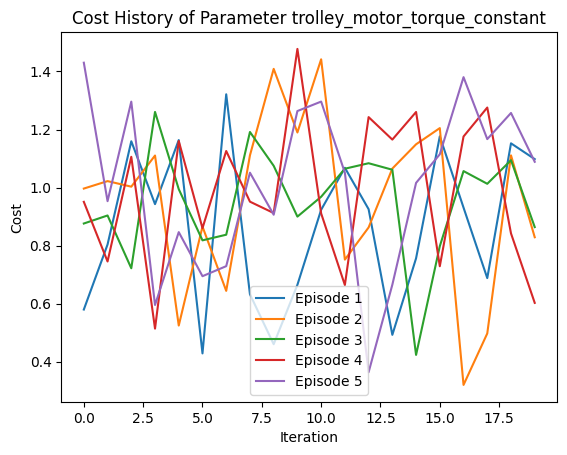

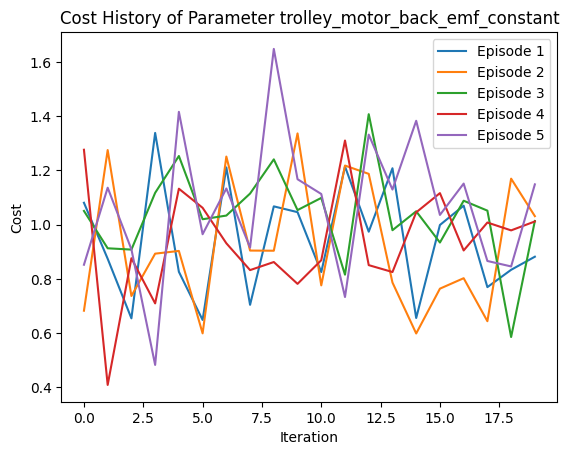

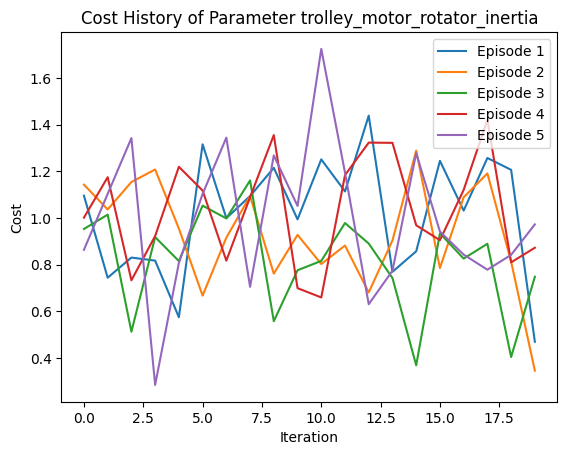

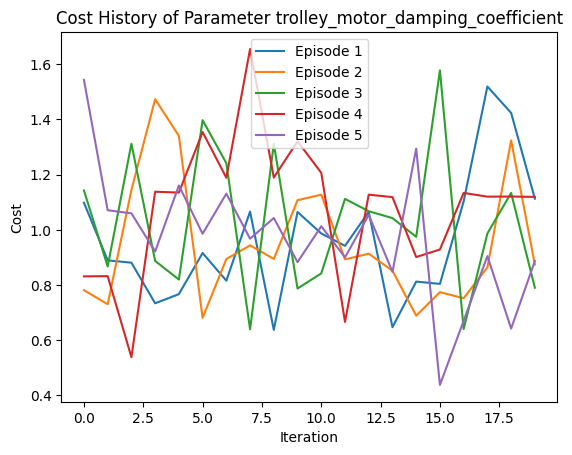

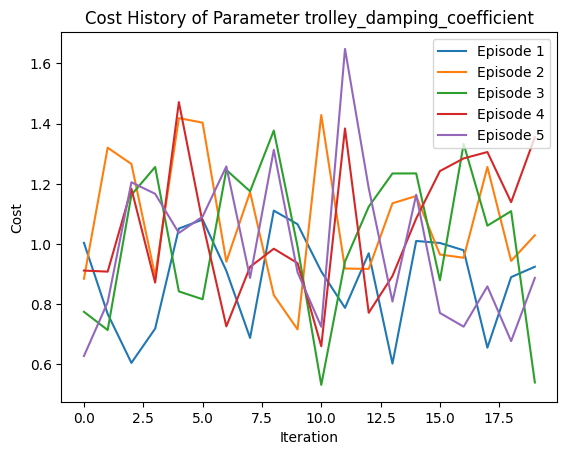

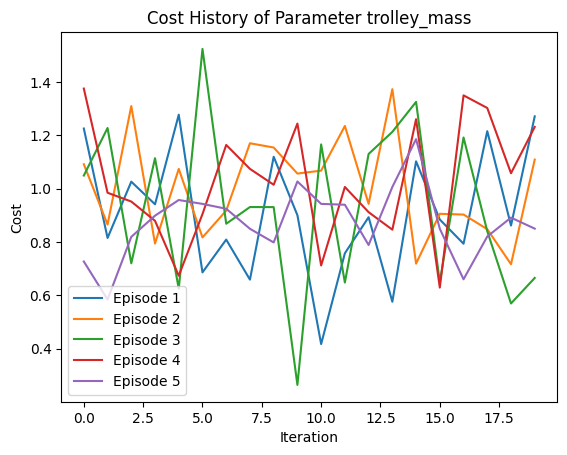

In [32]:
for parameter in parameters_cost_histories:
    cost_histories = parameters_cost_histories[parameter]
    for episode, cost in enumerate(cost_histories):
        plt.plot(cost, label=f"Episode {episode + 1}")
    plt.title(f"Cost History of Parameter {parameter}")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend()
    plt.show()

trolley_motor_torque_constant 1.9692802081125036, trolley_motor_back_emf_constant 5.726506976669284, trolley_motor_rotator_inertia 5.369652702054923, trolley_motor_damping_coefficient 17.053312426988008, trolley_damping_coefficient 4.201621952390951, trolley_motor_activation_threshold_voltage 4.0, hoist_motor_torque_constant 43.61869495637625, hoist_motor_back_emf_constant 1.1175991539712051, hoist_motor_rotator_inertia 4.18241058819926, hoist_motor_damping_coefficient 3.2574547621602594, cable_damping_coefficient 0.7363135538486685, hoist_motor_activation_threshold_voltage 2.23848215824154, trolley_mass 5.699671855965748, container_mass 1.028, gravity_acceleration 9.81, hoist_motor_inductance 0.0073, hoist_motor_resistance 9.5, hoist_motor_pulley_radius 0.0075, trolley_motor_inductance 0.0001048, trolley_motor_resistance 0.39, trolley_motor_pulley_radius 0.0075, 


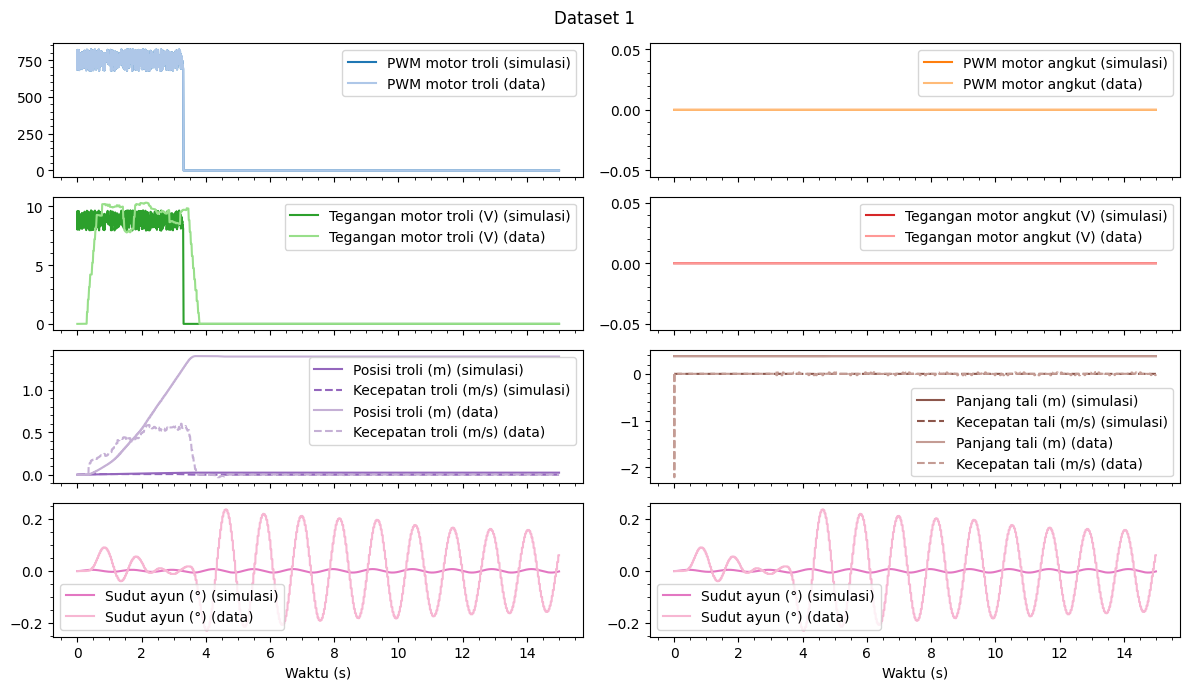

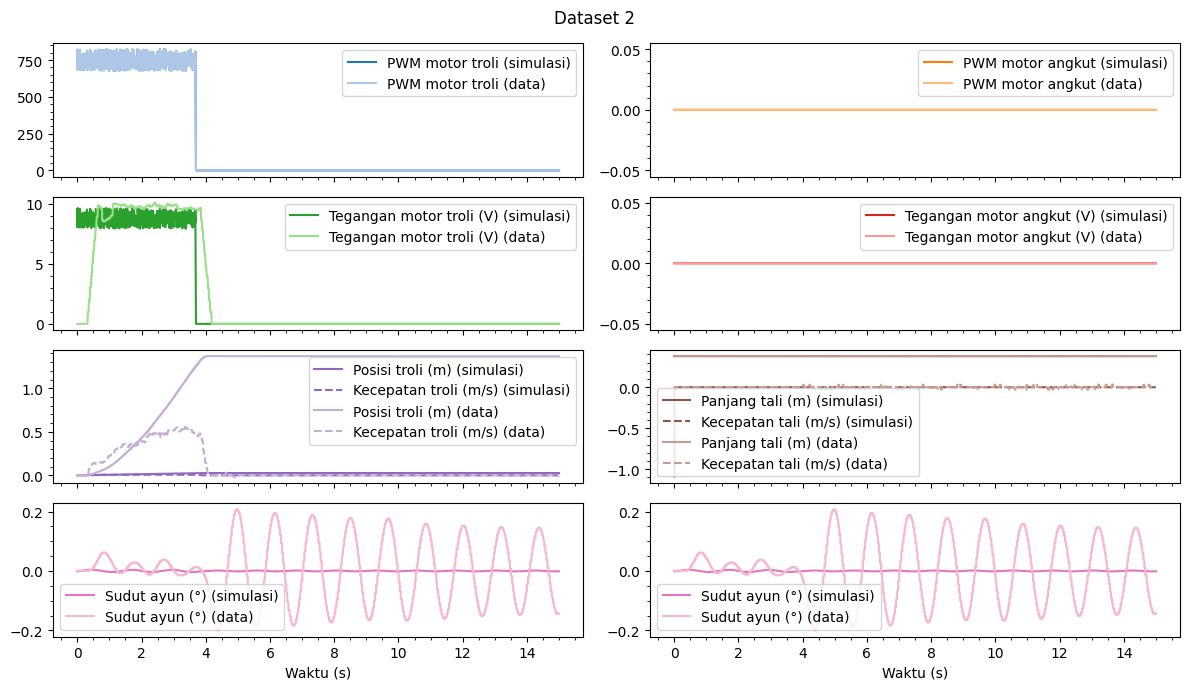

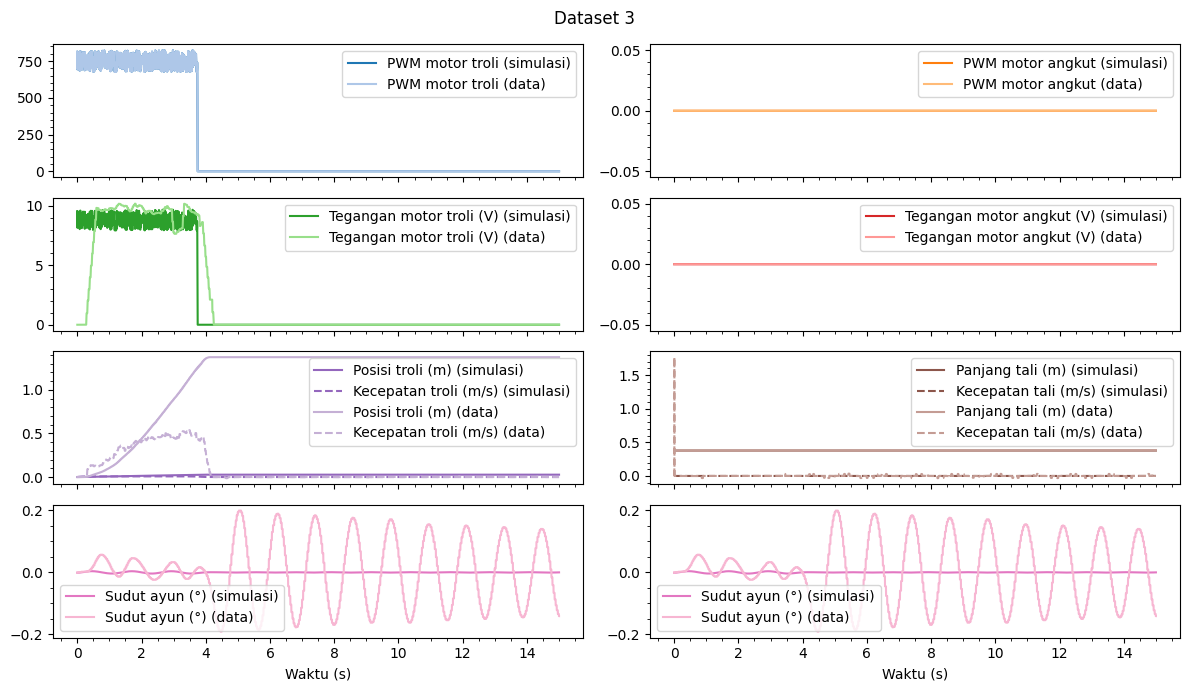

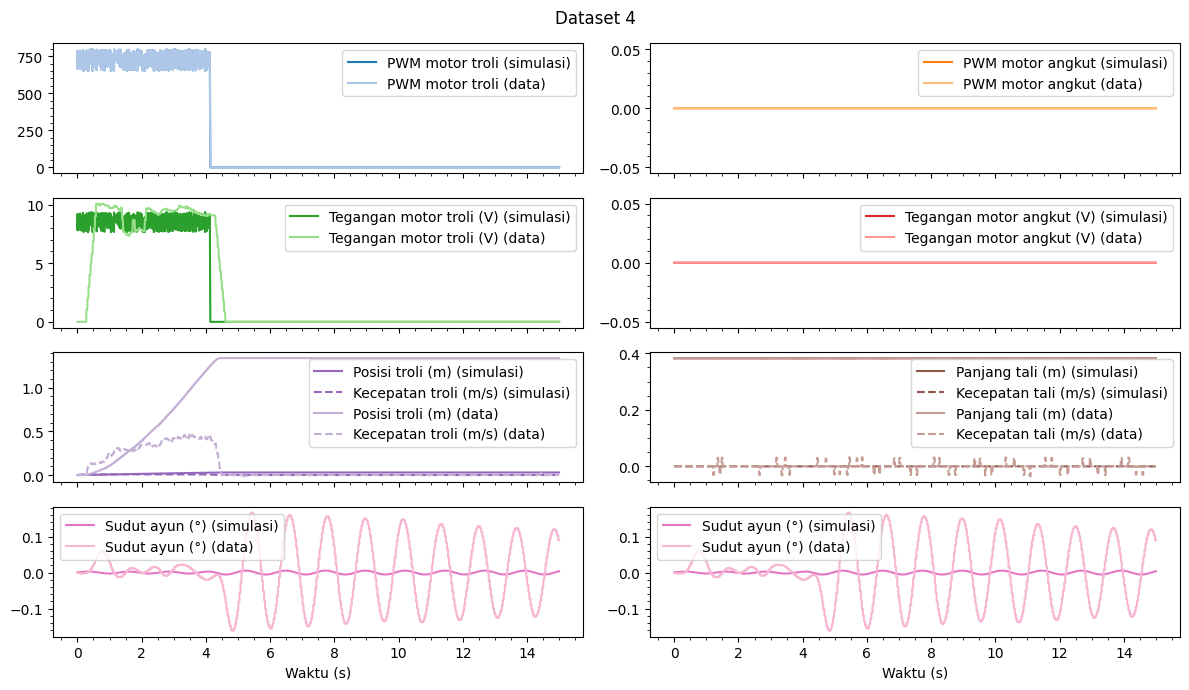

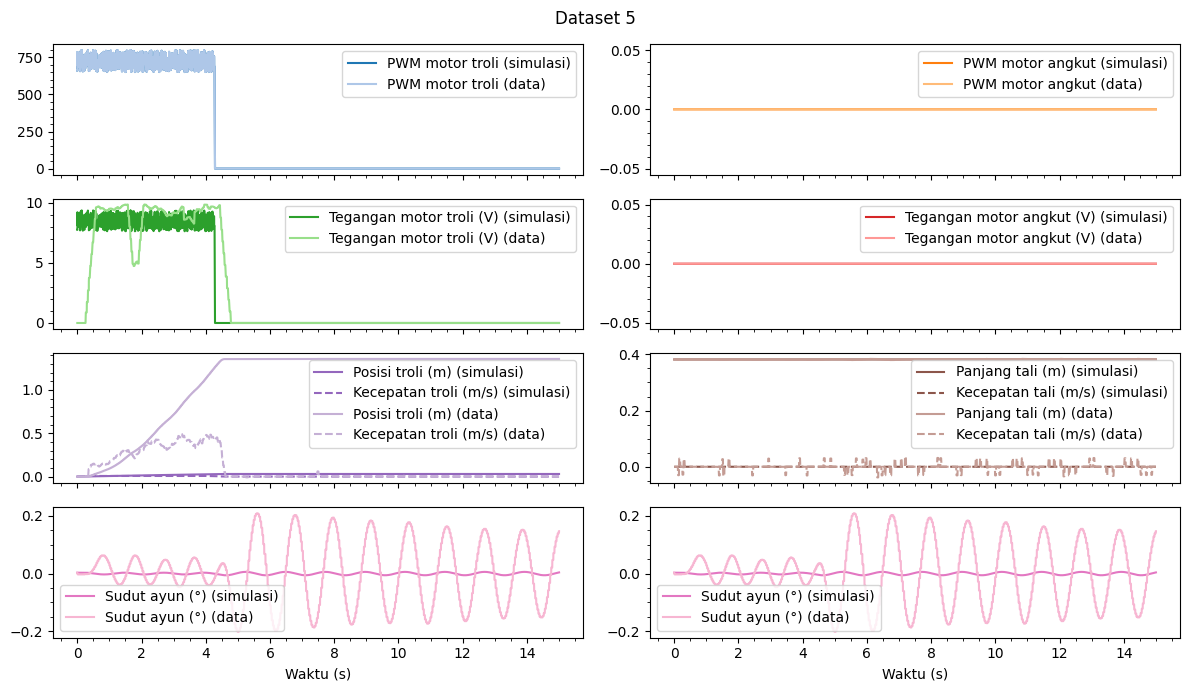

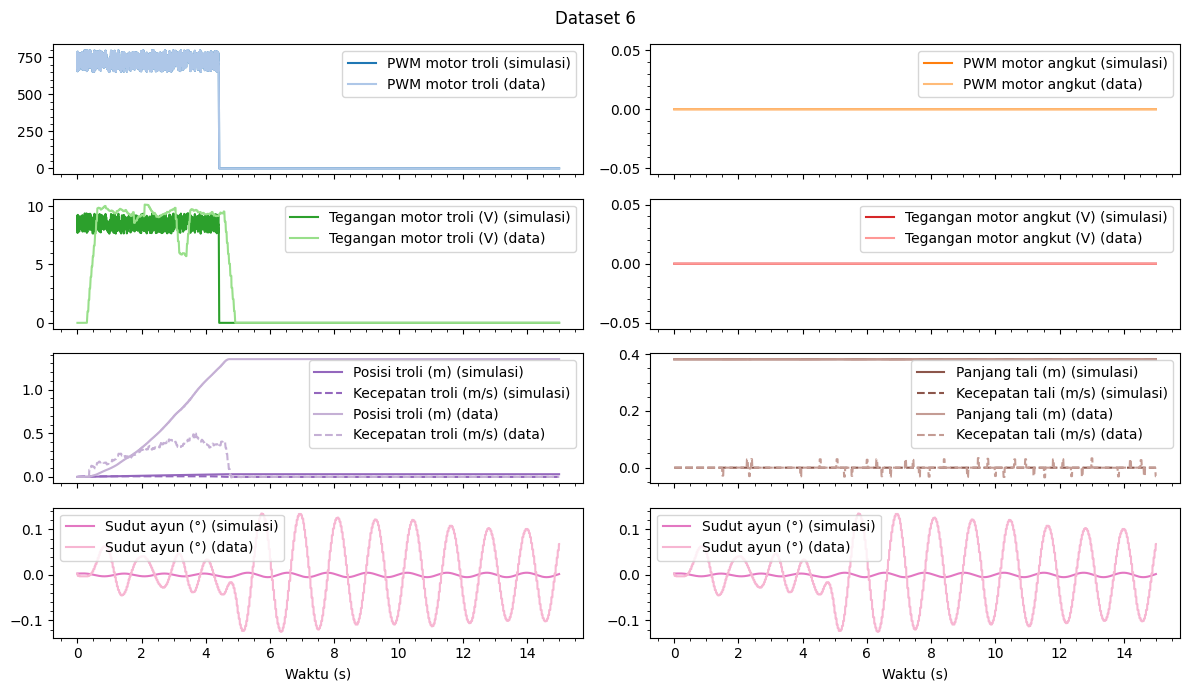

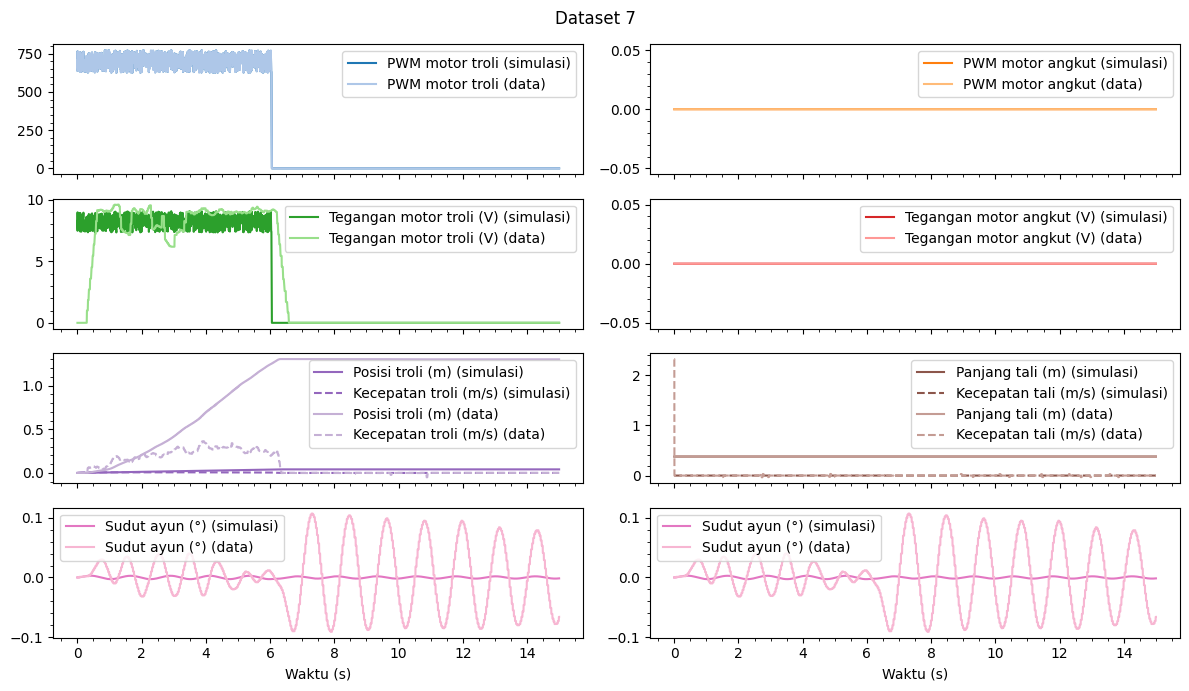

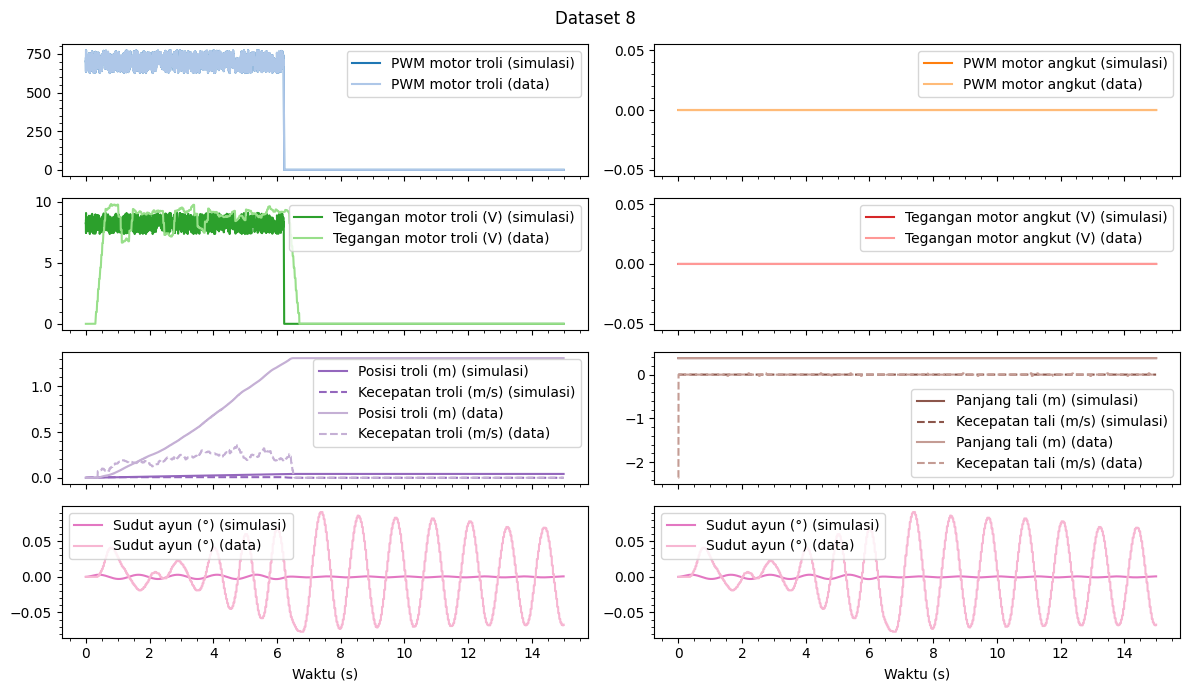

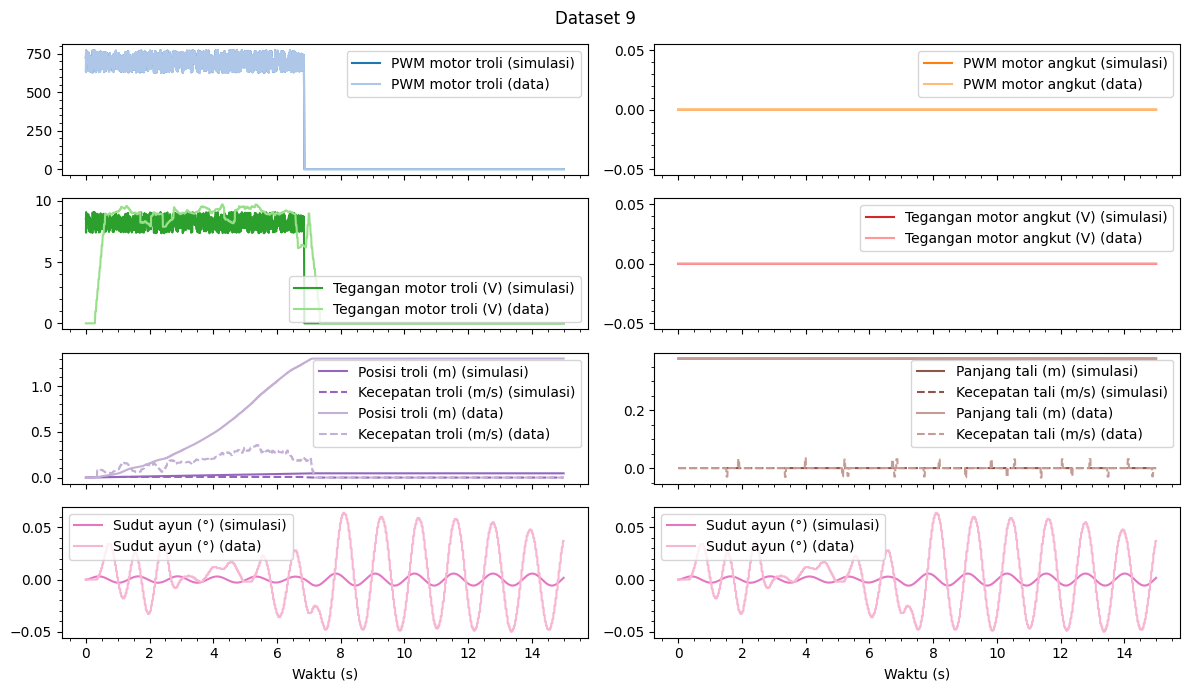

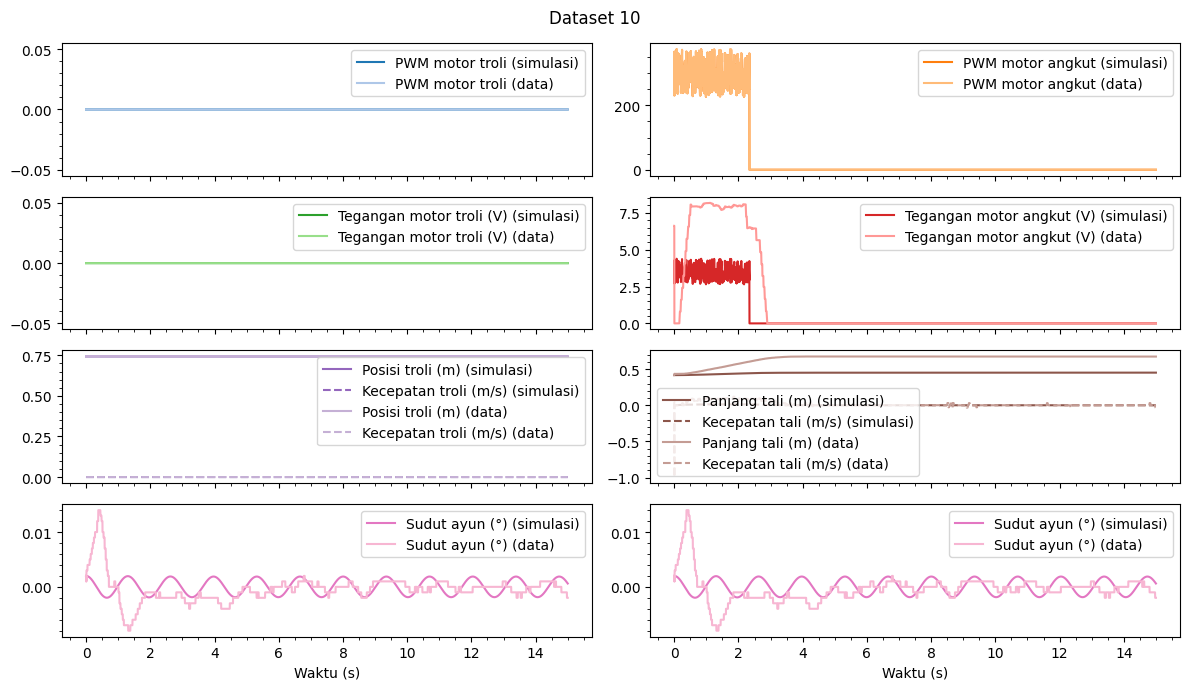

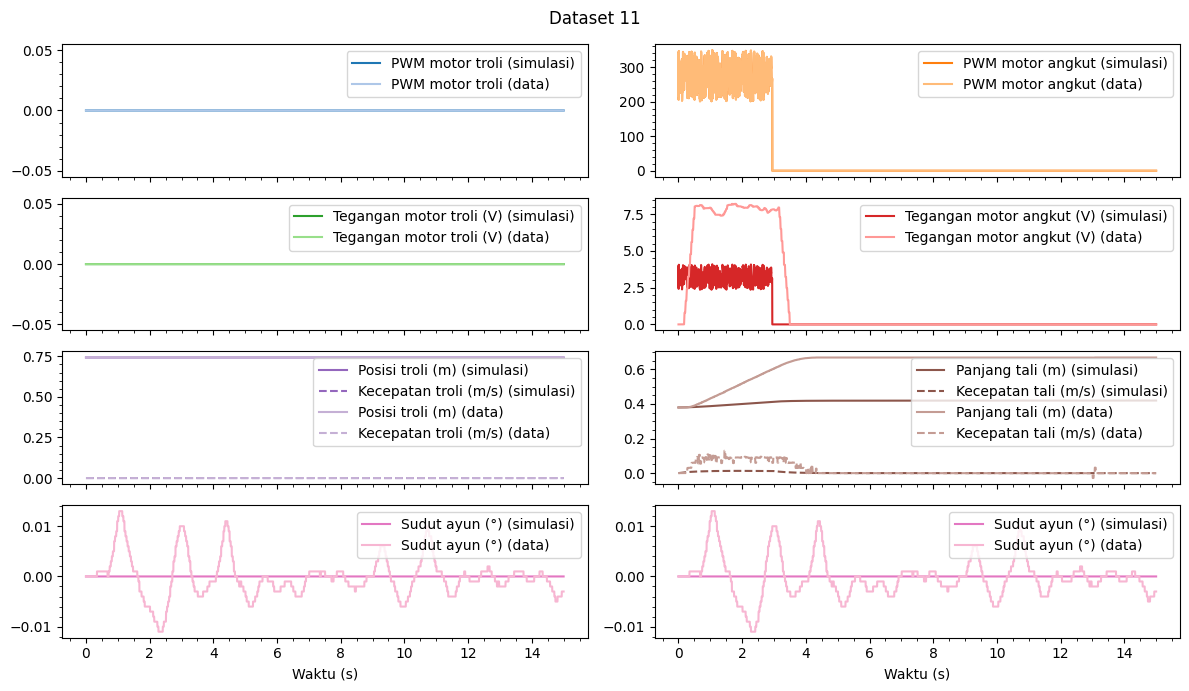

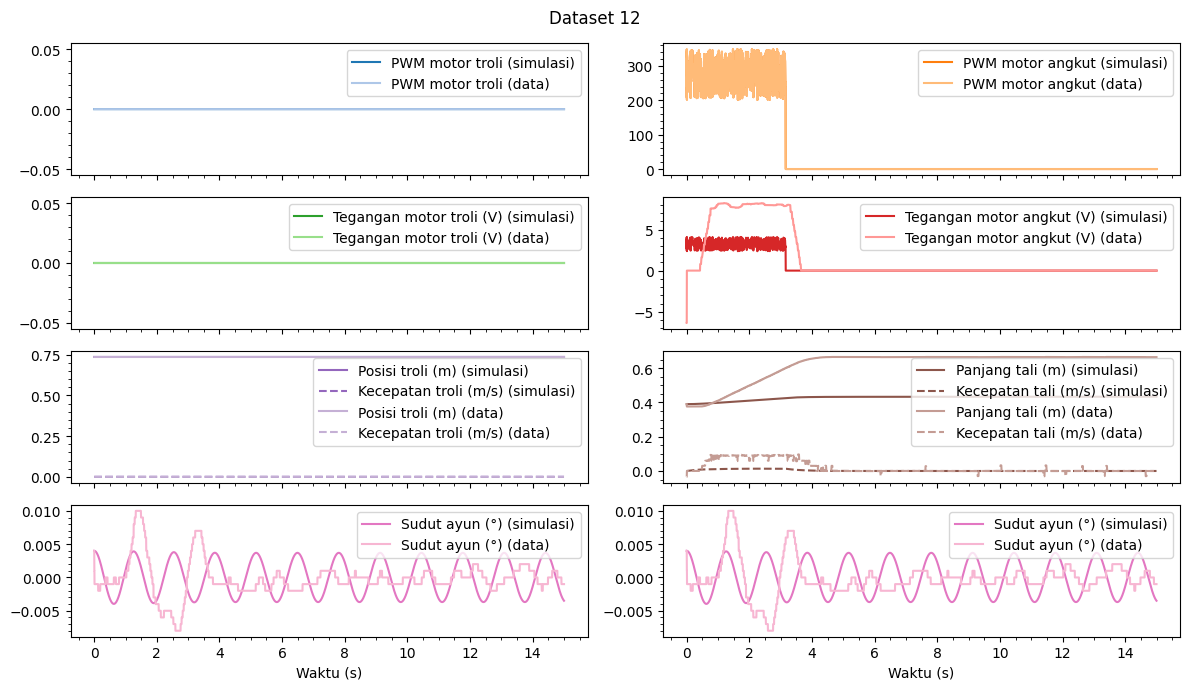

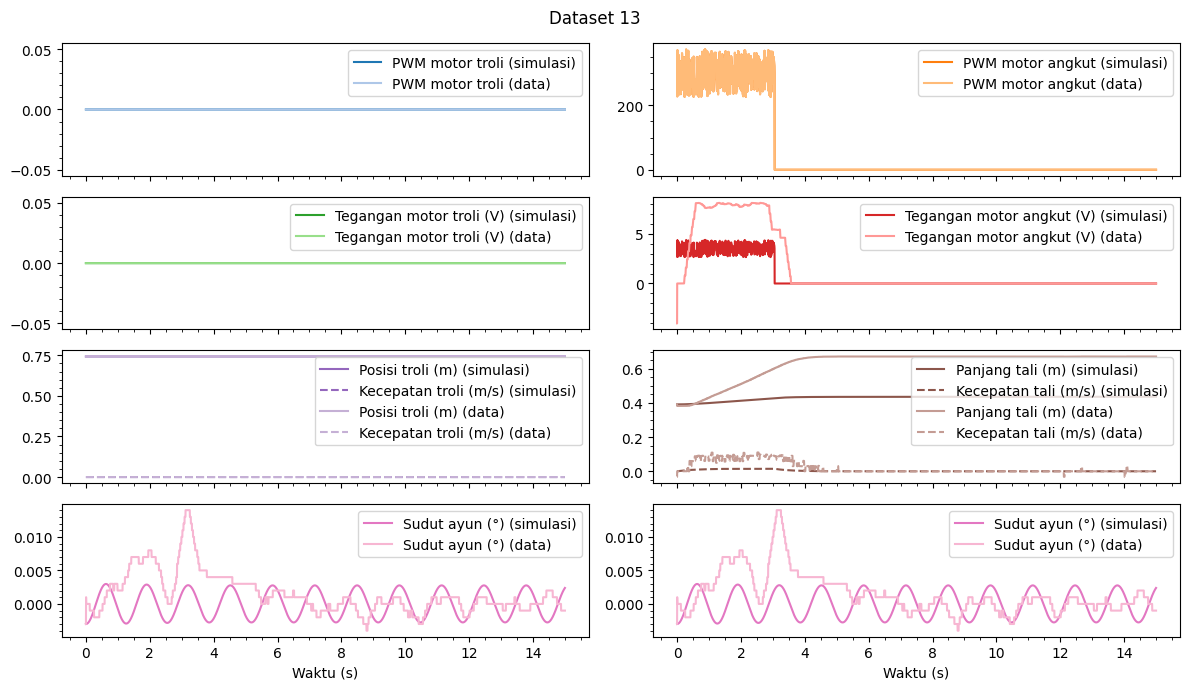

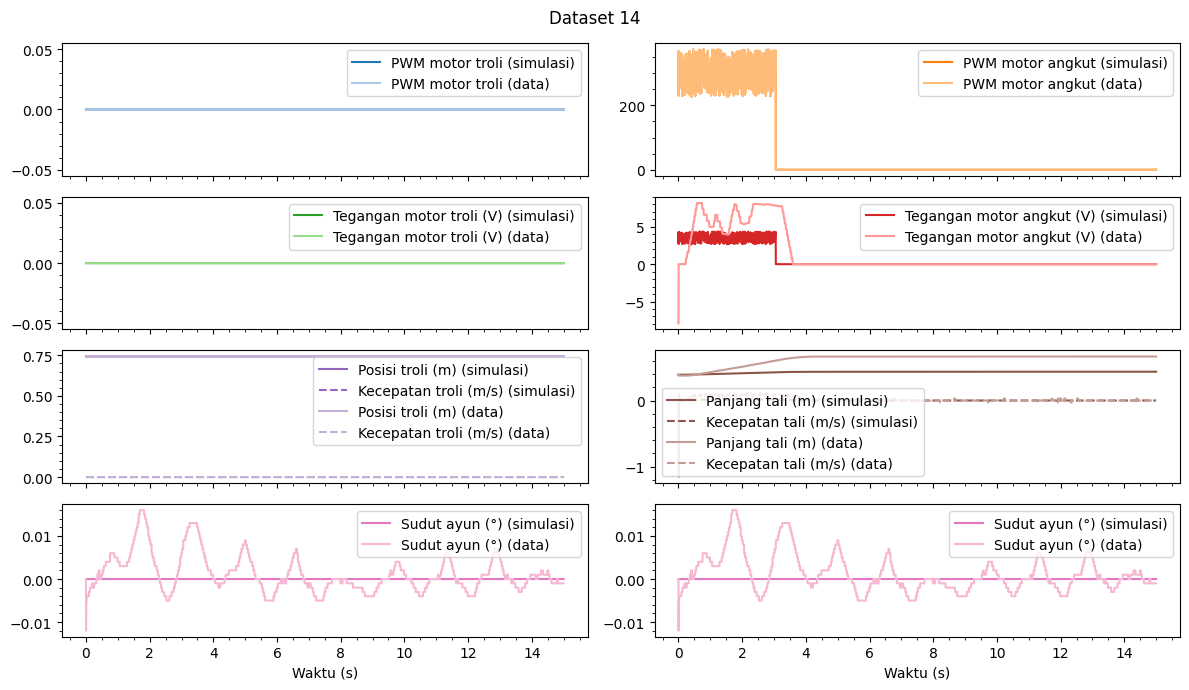

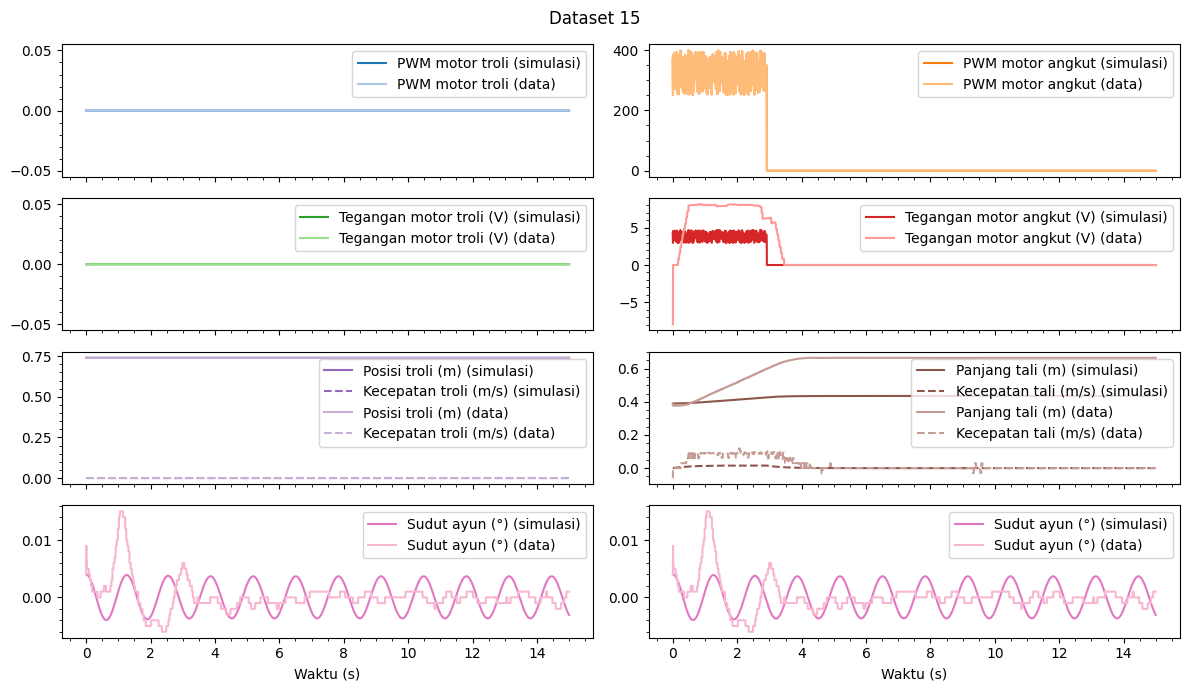

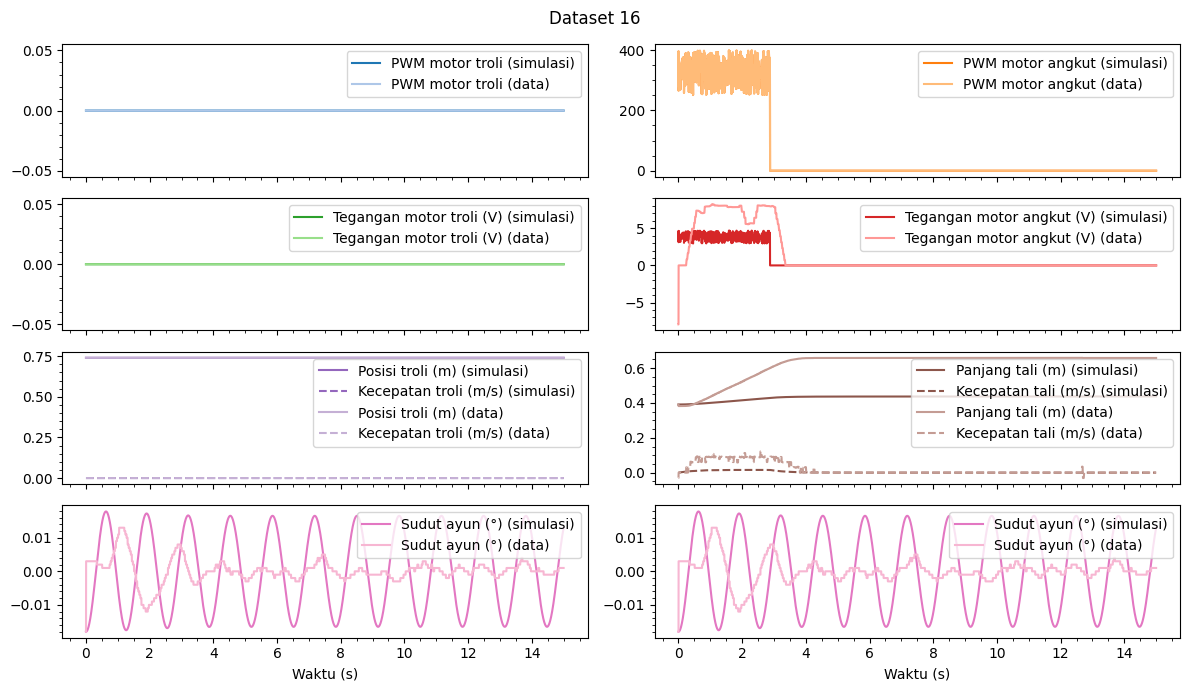

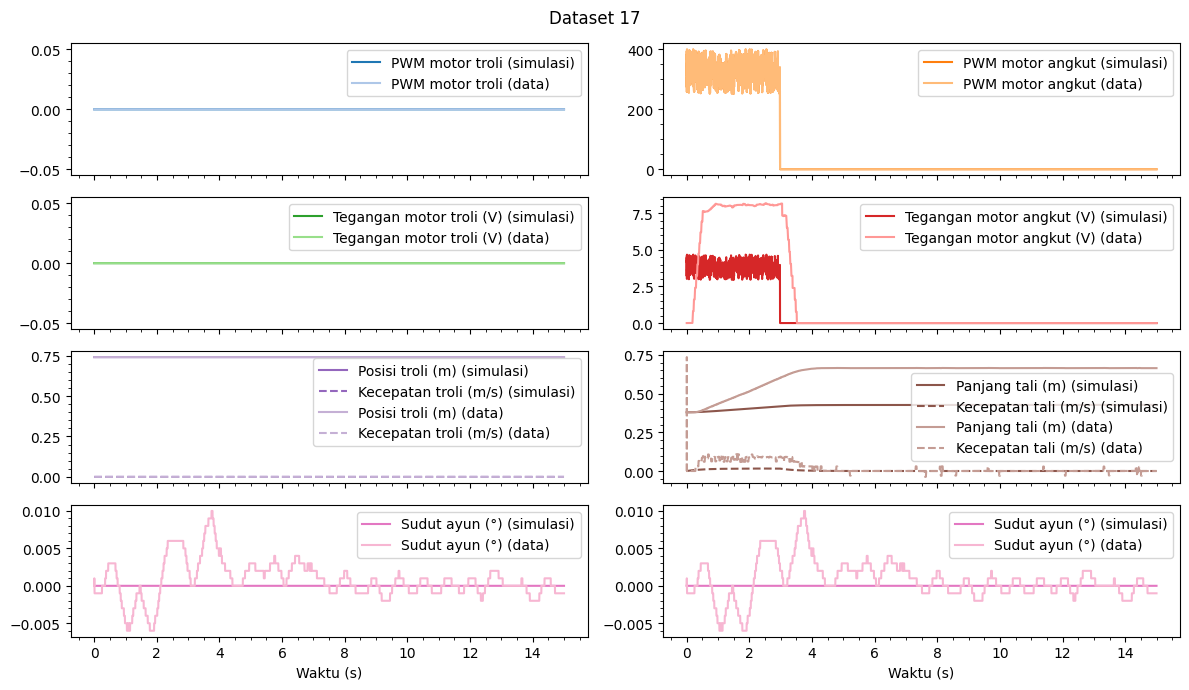

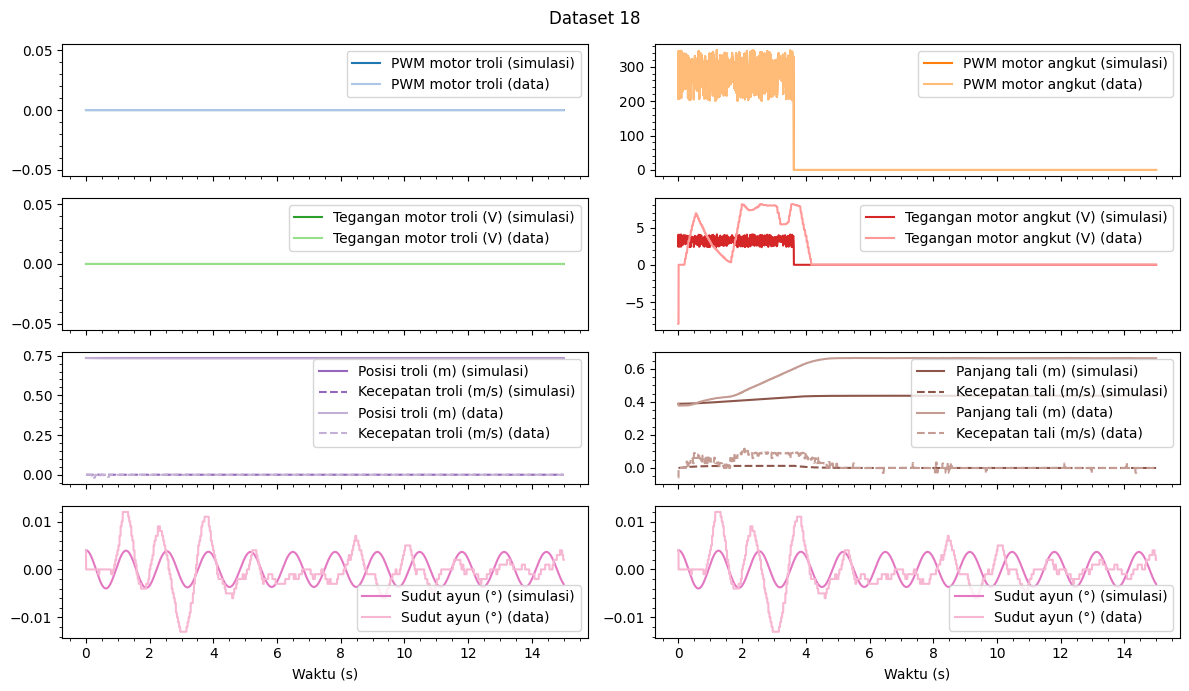

In [33]:
# Load the best parameters
best_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")
for parameter in best_parameters:
    print(parameter, best_parameters[parameter]["value"], end=", ")
print()

# Simulate the gantry crane system using the best parameters
for index, dataset in enumerate(interpolated_datasets):
    # if index >0:
    #     continue
    simulator.simulate(best_parameters, dataset["trolley_motor_pwm"], dataset["hoist_motor_pwm"], initial_conditions={"x": dataset["trolley_position"][0], "l": dataset["cable_length"][0], "theta": dataset["sway_angle"][0]})
    simulation_result = simulator.get_results()

    # Create a figure and a set of subplots
    figure, ax = plt.subplots(4, 2, figsize=(12, 7), sharex=True)
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(f"Dataset {index+1}")
    ut.add_to_subplot(ax[0, 0], simulation_result["time"], simulation_result["trolley_motor_pwm"], ylabel="PWM motor troli (simulasi)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], simulation_result["time"], simulation_result["hoist_motor_pwm"], ylabel="PWM motor angkut (simulasi)", color=plt.get_cmap("tab20")(2))
    ut.add_to_subplot(ax[1, 0], simulation_result["time"], simulation_result["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (simulasi)", color=plt.get_cmap("tab20")(4))
    ut.add_to_subplot(ax[1, 1], simulation_result["time"], simulation_result["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (simulasi)", color=plt.get_cmap("tab20")(6))
    ut.add_to_subplot(ax[2, 0], simulation_result["time"], simulation_result["trolley_position"], ylabel="Posisi troli (m) (simulasi)", color=plt.get_cmap("tab20")(8))
    ut.add_to_subplot(ax[2, 0], simulation_result["time"], simulation_result["trolley_speed"], ylabel="Kecepatan troli (m/s) (simulasi)", color=plt.get_cmap("tab20")(8), linestyle="--")
    ut.add_to_subplot(ax[2, 1], simulation_result["time"], simulation_result["cable_length"], ylabel="Panjang tali (m) (simulasi)", color=plt.get_cmap("tab20")(10))
    ut.add_to_subplot(ax[2, 1], simulation_result["time"], simulation_result["cable_speed"], ylabel="Kecepatan tali (m/s) (simulasi)", color=plt.get_cmap("tab20")(10), linestyle="--")
    ut.add_to_subplot(ax[3, 0], simulation_result["time"], simulation_result["sway_angle"], "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[3, 1], simulation_result["time"], simulation_result["sway_angle"], "Waktu (s)", "Sudut ayun (°) (simulasi)", color=plt.get_cmap("tab20")(12))

    ut.add_to_subplot(ax[0, 0], dataset["time"], dataset["trolley_motor_pwm"], ylabel="PWM motor troli (data)", color=plt.get_cmap("tab20")(1))
    ut.add_to_subplot(ax[0, 1], dataset["time"], dataset["hoist_motor_pwm"], ylabel="PWM motor angkut (data)", color=plt.get_cmap("tab20")(3))
    ut.add_to_subplot(ax[1, 0], dataset["time"], dataset["trolley_motor_voltage"], ylabel="Tegangan motor troli (V) (data)", color=plt.get_cmap("tab20")(5))
    ut.add_to_subplot(ax[1, 1], dataset["time"], dataset["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V) (data)", color=plt.get_cmap("tab20")(7))
    ut.add_to_subplot(ax[2, 0], dataset["time"], dataset["trolley_position"], ylabel="Posisi troli (m) (data)", color=plt.get_cmap("tab20")(9))
    ut.add_to_subplot(ax[2, 0], dataset["time"], dataset["trolley_speed"], ylabel="Kecepatan troli (m/s) (data)", color=plt.get_cmap("tab20")(9), linestyle="--")
    ut.add_to_subplot(ax[2, 1], dataset["time"], dataset["cable_length"], ylabel="Panjang tali (m) (data)", color=plt.get_cmap("tab20")(11))
    ut.add_to_subplot(ax[2, 1], dataset["time"], dataset["cable_speed"], ylabel="Kecepatan tali (m/s) (data)", color=plt.get_cmap("tab20")(11), linestyle="--")
    ut.add_to_subplot(ax[3, 0], dataset["time"], dataset["sway_angle"], "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(13))
    ut.add_to_subplot(ax[3, 1], dataset["time"], dataset["sway_angle"], "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(13))
    # ax[3, 0].set_ylim(-max_sway_angle, max_sway_angle)
    # ax[3, 1].set_ylim(-max_sway_angle, max_sway_angle)
    plt.tight_layout()
    plt.show()